In [1]:
%matplotlib notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [8]:
%matplotlib inline


# Restricted Boltzmann Machine features for digit classification


For greyscale image data where pixel values can be interpreted as degrees of
blackness on a white background, like handwritten digit recognition, the
Bernoulli Restricted Boltzmann machine model (:class:`BernoulliRBM
<sklearn.neural_network.BernoulliRBM>`) can perform effective non-linear
feature extraction.

In order to learn good latent representations from a small dataset, we
artificially generate more labeled data by perturbing the training data with
linear shifts of 1 pixel in each direction.

This example shows how to build a classification pipeline with a BernoulliRBM
feature extractor and a :class:`LogisticRegression
<sklearn.linear_model.LogisticRegression>` classifier. The hyperparameters
of the entire model (learning rate, hidden layer size, regularization)
were optimized by grid search, but the search is not reproduced here because
of runtime constraints.

Logistic regression on raw pixel values is presented for comparison. The
example shows that the features extracted by the BernoulliRBM help improve the
classification accuracy.


In [3]:
from __future__ import print_function

print(__doc__)

# Authors: Yann N. Dauphin, Vlad Niculae, Gabriel Synnaeve
# License: BSD

import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline

Automatically created module for IPython interactive environment


Setting up


In [4]:
def nudge_dataset(X, Y):
    """
    This produces a dataset 5 times bigger than the original one,
    by moving the 8x8 images in X around by 1px to left, right, down, up
    """
    direction_vectors = [
        [[0, 1, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [1, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 1],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 1, 0]]]

    shift = lambda x, w: convolve(x.reshape((8, 8)), mode='constant',
                                  weights=w).ravel()
    X = np.concatenate([X] +
                       [np.apply_along_axis(shift, 1, X, vector)
                        for vector in direction_vectors])
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    return X, Y

# Load Data
digits = datasets.load_digits()
X = np.asarray(digits.data, 'float32')
X, Y = nudge_dataset(X, digits.target)
X = (X - np.min(X, 0)) / (np.max(X, 0) + 0.0001)  # 0-1 scaling

X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.2,
                                                    random_state=0)

# Models we will use
logistic = linear_model.LogisticRegression()
rbm = BernoulliRBM(random_state=0, verbose=True)

classifier = Pipeline(steps=[('rbm', rbm), ('logistic', logistic)])

Training


In [5]:
# Hyper-parameters. These were set by cross-validation,
# using a GridSearchCV. Here we are not performing cross-validation to
# save time.
rbm.learning_rate = 0.06
rbm.n_iter = 20
# More components tend to give better prediction performance, but larger
# fitting time
rbm.n_components = 100
logistic.C = 6000.0

# Training RBM-Logistic Pipeline
classifier.fit(X_train, Y_train)

# Training Logistic regression
logistic_classifier = linear_model.LogisticRegression(C=100.0)
logistic_classifier.fit(X_train, Y_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -25.39, time = 0.24s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -23.77, time = 0.29s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -22.94, time = 0.29s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -21.91, time = 0.28s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -21.69, time = 0.28s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -21.06, time = 0.28s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -20.89, time = 0.28s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -20.64, time = 0.27s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -20.36, time = 0.27s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -20.09, time = 0.27s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -20.08, time = 0.27s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -19.82, time = 0.27s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -19.64, time = 0.27s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -19.61, time = 0.27s
[BernoulliRBM] Iteration 15, 

Pipeline(steps=[('rbm', BernoulliRBM(batch_size=10, learning_rate=0.06, n_components=100, n_iter=20,
       random_state=0, verbose=True)), ('logistic', LogisticRegression(C=6000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Evaluation


In [6]:
print()
print("Logistic regression using RBM features:\n%s\n" % (
    metrics.classification_report(
        Y_test,
        classifier.predict(X_test))))

print("Logistic regression using raw pixel features:\n%s\n" % (
    metrics.classification_report(
        Y_test,
        logistic_classifier.predict(X_test))))


Logistic regression using RBM features:
             precision    recall  f1-score   support

          0       0.99      0.99      0.99       174
          1       0.92      0.95      0.93       184
          2       0.95      0.98      0.97       166
          3       0.97      0.91      0.94       194
          4       0.97      0.95      0.96       186
          5       0.93      0.93      0.93       181
          6       0.98      0.97      0.97       207
          7       0.95      1.00      0.97       154
          8       0.90      0.88      0.89       182
          9       0.91      0.93      0.92       169

avg / total       0.95      0.95      0.95      1797


Logistic regression using raw pixel features:
             precision    recall  f1-score   support

          0       0.85      0.94      0.89       174
          1       0.57      0.55      0.56       184
          2       0.72      0.85      0.78       166
          3       0.76      0.74      0.75       194
       

Plotting


([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

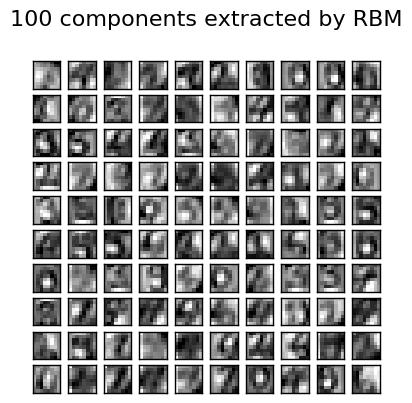

In [9]:
plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(rbm.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((8, 8)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('100 components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()